# RFM, Apriori Algorithm, Item Based Collaborative Filtering
## Objective
To compare the market Apriori Algorithm and Item Based Collaborative Filtering.

Provide customized recommendations to customer based on customer segmentation derived from RFM analysis.


Dataset : https://www.kaggle.com/datasets/emrhn1031/online-retail-dataset?resource=download

Author : Sai Lalith Sistla

In [1]:
#Use As required to install libraries
# !pip install kneed
# !pip install mlxtend

In [52]:
# import library
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt


#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns


#For Machine Learning Algorithm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from kneed import KneeLocator

# For market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [3]:
df = pd.read_csv(r'./datasets/Online_Retail_Dataset kaggle.csv')
df.head(5)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396785 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   396785 non-null  int64         
 1   InvoiceNo    396785 non-null  object        
 2   StockCode    396785 non-null  object        
 3   Description  396785 non-null  object        
 4   Quantity     396785 non-null  float64       
 5   InvoiceDate  396785 non-null  datetime64[ns]
 6   UnitPrice    396785 non-null  float64       
 7   CustomerID   396785 non-null  float64       
 8   Country      396785 non-null  object        
 9   order_date   396785 non-null  datetime64[ns]
 10  order_time   396785 non-null  object        
 11  TotalSum     396785 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(5)
memory usage: 39.4+ MB


### Data Cleansing and pre-processing

- DUplicate Data 
- Null value treatment
- Range / outlier treatment

In [ ]:
# Cleanse all string columns of spaces
string_columns = df.select_dtypes(include=['object', 'string']).columns
df[string_columns] = df[string_columns].apply(lambda x: x.str.strip())

In [4]:
#check and clean duplicate data
print("Duplicates Before : ", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates After : ", df.duplicated().sum())

Duplicates Before :  0
Duplicates After :  0


In [5]:
df.isnull().sum()

Unnamed: 0          0
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# CustomerID helps to bin the treansactions and as such null in the columns will not be useful for analysis
df= df.dropna(subset=['CustomerID'])

In [7]:
df.describe()

,Unnamed: 0,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,278048.159318,12.061303,3.460471,15287.690570
std,152744.019884,248.693370,69.315162,1713.600303
min,0.000000,-80995.000000,0.000000,12346.000000
25%,147749.000000,2.000000,1.250000,13953.000000
50%,284435.000000,5.000000,1.950000,15152.000000
75%,409528.000000,12.000000,3.750000,16791.000000
max,541908.000000,80995.000000,38970.000000,18287.000000


In [8]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe()

,Unnamed: 0,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,278462.993893,12.988238,3.116488,15294.423453
std,152770.852038,179.331775,22.097877,1713.141560
min,0.000000,1.000000,0.001000,12346.000000
25%,148333.750000,2.000000,1.250000,13969.000000
50%,284902.500000,6.000000,1.950000,15159.000000
75%,410074.250000,12.000000,3.750000,16795.000000
max,541908.000000,80995.000000,8142.750000,18287.000000


In [9]:
df.groupby('Description').agg(
    count=('InvoiceNo', 'count'), 
    distinct_count=('InvoiceNo', lambda x: x.nunique())
).sort_values(by='distinct_count', ascending=False).head(20)

,count,distinct_count
Description,,
WHITE HANGING HEART T-LIGHT HOLDER,2028,1971
REGENCY CAKESTAND 3 TIER,1723,1703
JUMBO BAG RED RETROSPOT,1618,1600
PARTY BUNTING,1396,1379
ASSORTED COLOUR BIRD ORNAMENT,1408,1375
LUNCH BAG RED RETROSPOT,1316,1288
SET OF 3 CAKE TINS PANTRY DESIGN,1159,1146
POSTAGE,1099,1099
LUNCH BAG BLACK SKULL.,1105,1052


In [10]:
# Removing "Postage" as it is not an item for sale
print(df.shape)
df = df[(df['Description'] != 'POSTAGE')]
print(df.shape)

(397884, 9)
(396785, 9)


In [11]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df['order_date'] = [d.date() for d in df['InvoiceDate']]
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_time'] = [d.time() for d in df['InvoiceDate']]

df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time
0,0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


In [12]:
#New Total Sum Column  
df['TotalSum'] = df['UnitPrice']* df['Quantity']

#Data preparation steps
print('Min Invoice Date:', df.order_date.dt.date.min(),'\nmax Invoice Date:', df.order_date.dt.date.max())

Min Invoice Date: 2010-12-01 
max Invoice Date: 2011-12-09


In [13]:
df.head(3)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,order_time,TotalSum
0,0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,15.30
1,1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,20.34
2,2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,22.00


In [14]:
snapshot_date = df['order_date'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 00:00:00')

#### Observation: 

- The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, let's set one day after the last one,or 10 DEC as a snapshot_date. We will count the diff days with snapshot_date.

### Calculate RFM Metrics

In [15]:
rfm = df.groupby(['CustomerID']).agg({
    'order_date': lambda x : (snapshot_date - x.max()).days,
    'InvoiceNo':'count',
    'TotalSum': 'sum'
})

In [16]:
rfm.rename(columns={'order_date':'Recency','InvoiceNo':'Frequency',
'TotalSum':'MonetaryValue'},inplace= True)
#Final RFM values
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,27,1437.24
12349.0,19,72,1457.55
12350.0,311,16,294.40


#### Note: 

We will rate “Recency” customer who have been active more recently better than the less recent customer, because each company wants its customers to be recent.

We will rate “Frequency” and “Monetary Value” higher label because we want customer to spend more money and visit more often (that is different order than recency).

In [17]:
r_labels =range(4,0,-1)

f_labels=range(1,5)

m_labels=range(1,5)

r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)

f_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = f_labels)

m_quartiles = pd.qcut(rfm['MonetaryValue'],q=4,labels = m_labels)

rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score

def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])

rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
12347.0,3,182,4310.00,4,4,4,4.04.04.0,12
12348.0,76,27,1437.24,2,2,3,2.02.03.0,7
12349.0,19,72,1457.55,3,3,3,3.03.03.0,9
12350.0,311,16,294.40,1,1,1,1.01.01.0,3


#### Analyzing RFM Segments
It is always the best practice to investigate the size of the segments before you use them for targeting or other business application.

In [18]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
4.04.04.0    439
1.01.01.0    385
3.04.04.0    221
1.02.02.0    203
2.01.01.0    182
dtype: int64

In [19]:
rfm.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',

'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           262.1       8.2         157.7   385
4           174.5      13.6         238.3   386
5           153.6      21.2         363.5   520
6            96.2      28.1         819.0   457
7            81.2      38.5         758.2   458
8            64.0      56.3         985.7   462
9            47.0      80.2        1806.7   411
10           32.7     113.2        2049.6   423
11           21.3     187.0        3983.4   397
12            7.6     377.6        9393.9   439

In [20]:
def segments(df):
    if df['RFM_Score'] > 9 :
        return 'Gold'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Silver'
    else:
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments,axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',

'MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         264.7  1291
Gold               20.4     228.7        5220.3  1259
Silver             72.7      50.0        1073.6  1788

In [21]:
# Merged rfm and main dataframe
mdf=pd.merge(df,rfm,on='CustomerID')
mdf

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_date,...,TotalSum,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,...,15.30,373,297,5391.21,1,4,4,1.04.04.0,9,Silver
1,1,536365.0,71053.0,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,...,20.34,373,297,5391.21,1,4,4,1.04.04.0,9,Silver
2,2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,...,22.00,373,297,5391.21,1,4,4,1.04.04.0,9,Silver
3,3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,...,20.34,373,297,5391.21,1,4,4,1.04.04.0,9,Silver
4,4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,...,20.34,373,297,5391.21,1,4,4,1.04.04.0,9,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396780,541801,581578.0,22993.0,SET OF 4 PANTRY JELLY MOULDS,12.0,2011-12-09 12:16:00,1.25,12713.0,Germany,2011-12-09,...,15.00,1,37,794.55,4,2,3,4.02.03.0,9,Silver
396781,541802,581578.0,22907.0,PACK OF 20 NAPKINS PANTRY DESIGN,12.0,2011-12-09 12:16:00,0.85,12713.0,Germany,2011-12-09,...,10.20,1,37,794.55,4,2,3,4.02.03.0,9,Silver
396782,541803,581578.0,22908.0,PACK OF 20 NAPKINS RED APPLES,12.0,2011-12-09 12:16:00,0.85,12713.0,Germany,2011-12-09,...,10.20,1,37,794.55,4,2,3,4.02.03.0,9,Silver
396783,541804,581578.0,23215.0,JINGLE BELL HEART ANTIQUE SILVER,12.0,2011-12-09 12:16:00,2.08,12713.0,Germany,2011-12-09,...,24.96,1,37,794.55,4,2,3,4.02.03.0,9,Silver


In [22]:
# Created 3 data frames based on RFM segments to perform MBA.

Bronze_seg = mdf[mdf.General_Segment == 'Bronze']

Silver_seg = mdf[mdf.General_Segment == 'Bronze']

Gold_seg = mdf[mdf.General_Segment == 'Bronze']

### Data Pre-Processing for K-means Clustering
We must check these Key k-means assumptions before we implement our K-means clustering Mode

- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

In [23]:
def find_skewness(df, columns_to_check):
    for col_name in columns_to_check:
        # Calculate skewness
        skewness = skew(df[col_name])
        # Skewness interpretation
        if -0.5 <= skewness <= 0.5:
            interpretation = "The data is approximately symmetric. No fix needed."
        elif 0.5 < skewness <= 1:
            interpretation = "The data is moderately positively skewed. Consider applying a transformation if needed."
        elif skewness > 1:
            interpretation = "The data is highly positively skewed. A fix is recommended."
        elif -1 <= skewness < -0.5:
            interpretation = "The data is moderately negatively skewed. Consider applying a transformation if needed."
        else:
            interpretation = "The data is highly negatively skewed. A fix is recommended."
        print(f"Column name : {col_name} \t\t Skewness: {skewness:.2f} \t\t {interpretation}")
        
def plot_skewness(df, columns_to_check):
    # Set style
    plt.style.use('fivethirtyeight')

    # Create the subplots
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)

    # Plot Recency
    sns.histplot(rfm.Recency, kde=True, ax=axes[0], label='Recency')
    axes[0].set_title('Recency Distribution')

    # Plot Frequency
    sns.histplot(rfm.Frequency, kde=True, ax=axes[1], label='Frequency')
    axes[1].set_title('Frequency Distribution')

    # Plot Monetary Value
    sns.histplot(rfm.MonetaryValue, kde=True, ax=axes[2], label='Monetary Value')
    axes[2].set_title('Monetary Value Distribution')

    # Show the plots
    plt.show()

In [24]:
rfm_select = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_select.describe())

           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     93.089673    91.467266    2036.331015
std     100.014839   228.669221    8960.024748
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.210000
50%      51.000000    41.000000     668.125000
75%     143.000000   100.000000    1644.550000
max     374.000000  7847.000000  279138.020000


#### Observations : 

From this table, we find this problem: Mean and Variance are not Equal

Solution: Scaling variables by using a scaler from scikit-learn library

## Plot the distribution of RFM values

Column name : Recency 		 Skewness: 1.24 		 The data is highly positively skewed. A fix is recommended.
Column name : Frequency 		 Skewness: 18.12 		 The data is highly positively skewed. A fix is recommended.
Column name : MonetaryValue 		 Skewness: 19.38 		 The data is highly positively skewed. A fix is recommended.


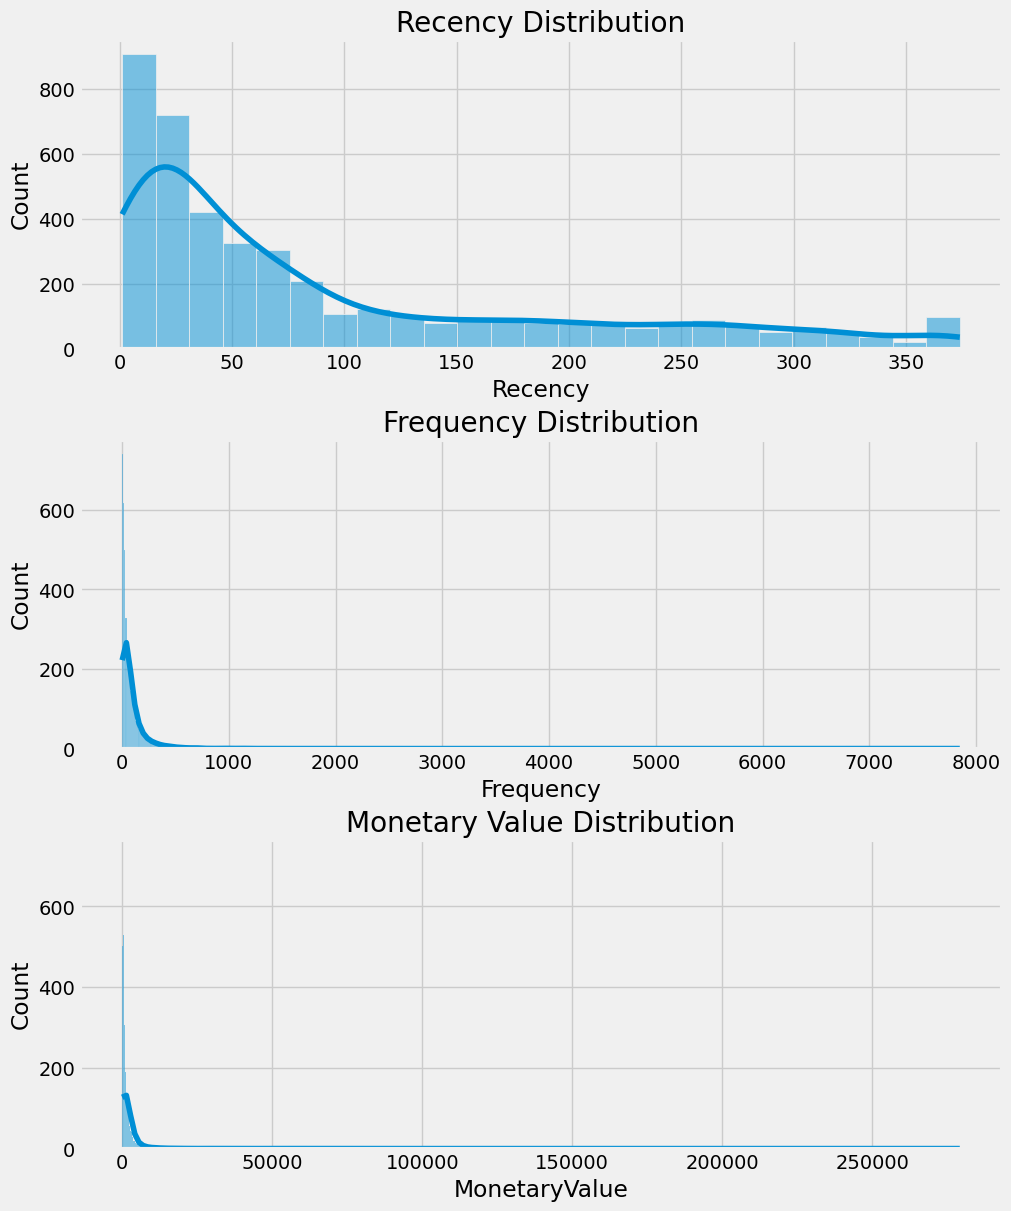

In [25]:
find_skewness(rfm, ['Recency','Frequency','MonetaryValue'])
plot_skewness(rfm, ['Recency','Frequency','MonetaryValue'])


#### Observations : 

Also, there is another Problem: Unsymmetric distribution of variables (Data skewed)

Solution: Logarithmic transformation (positive values only) will manage skewness


We use these Sequence of structuring pre-processing steps:

1. Unskew the data – log transformation

2. Standardize to the same average values

3. Scale to the same standard deviation

4. Store as a separate array to be used for clustering

Why the Sequence Matters?

Log transformation only works with positive data
Normalization forces data to have negative values and log will not work

### Unskew the data with log transformation

In [26]:
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)

Column name : Recency 		 Skewness: -0.47 		 The data is approximately symmetric. No fix needed.
Column name : Frequency 		 Skewness: -0.22 		 The data is approximately symmetric. No fix needed.
Column name : MonetaryValue 		 Skewness: 0.38 		 The data is approximately symmetric. No fix needed.


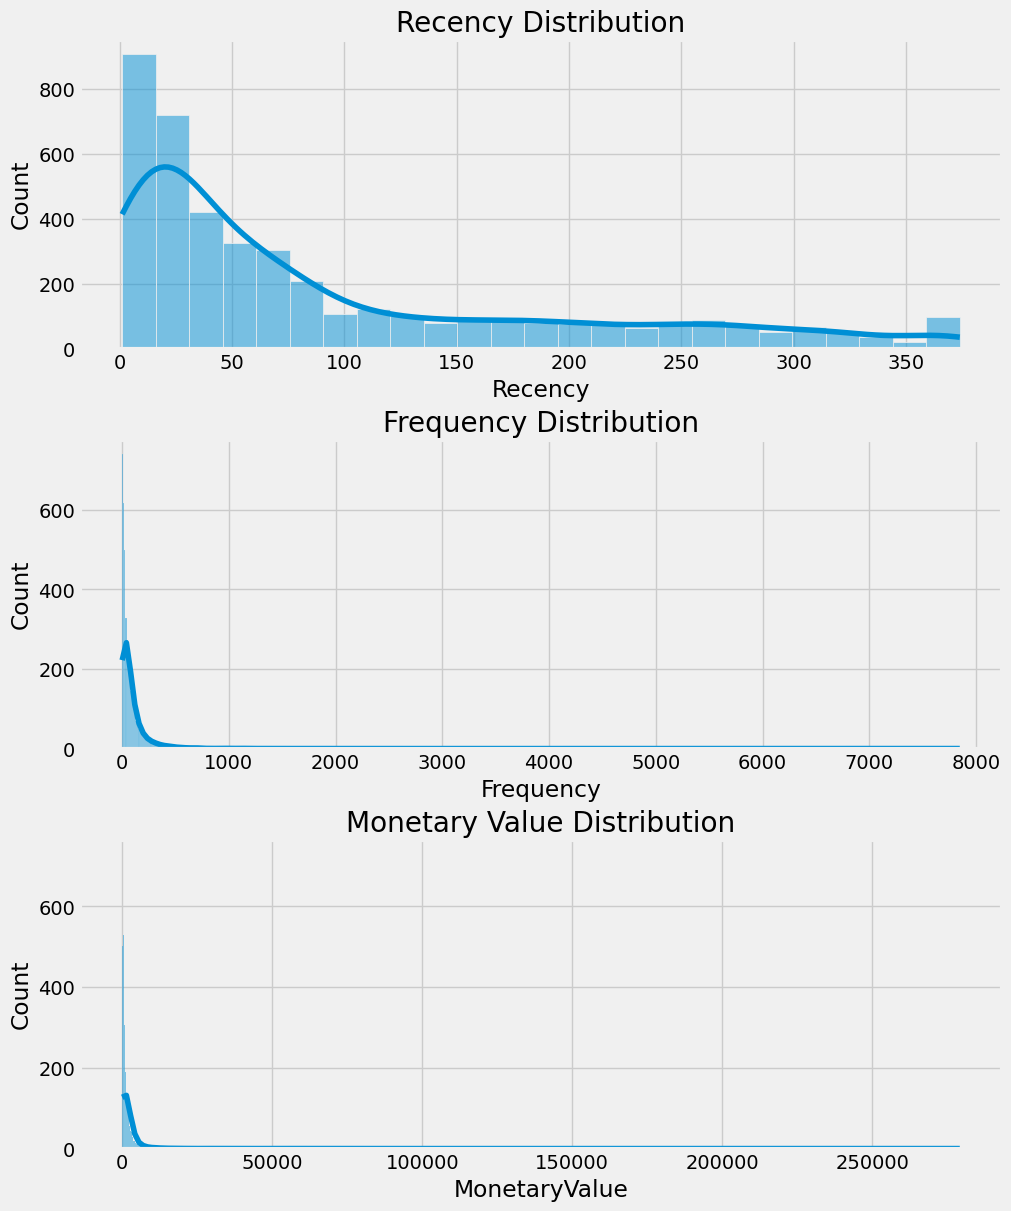

In [27]:
find_skewness(rfm_log, ['Recency','Frequency','MonetaryValue'])
plot_skewness(rfm_log, ['Recency','Frequency','MonetaryValue'])

In [28]:
#Normalize the variables with StandardScaler

scaler = StandardScaler()
scaler.fit(rfm_log)

#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

### Implementation of K-Means Clustering

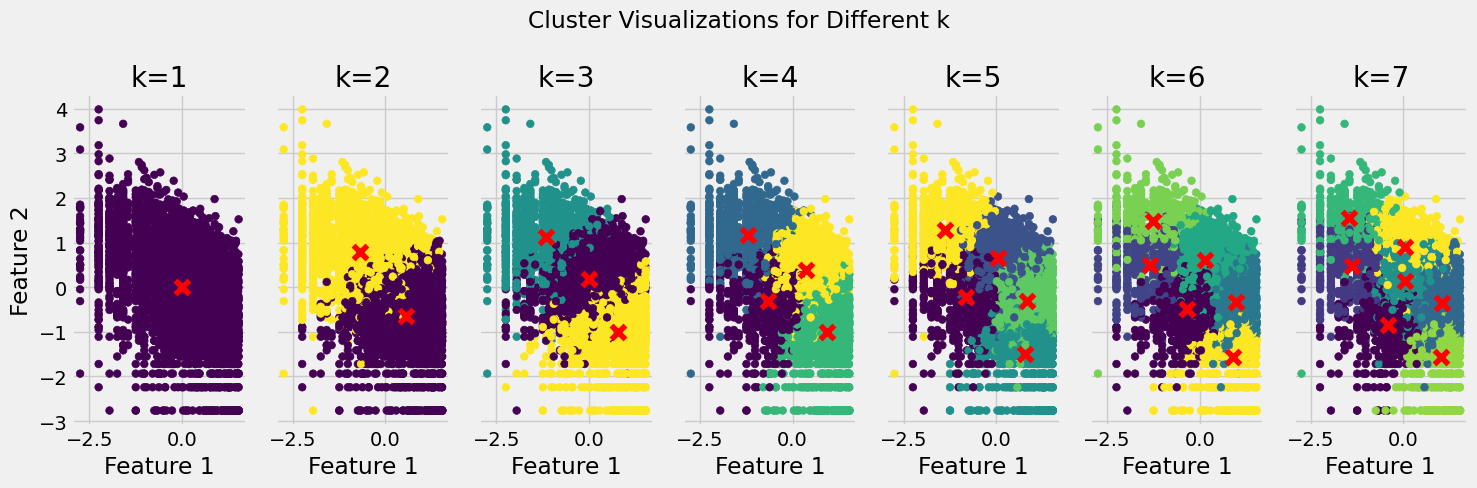

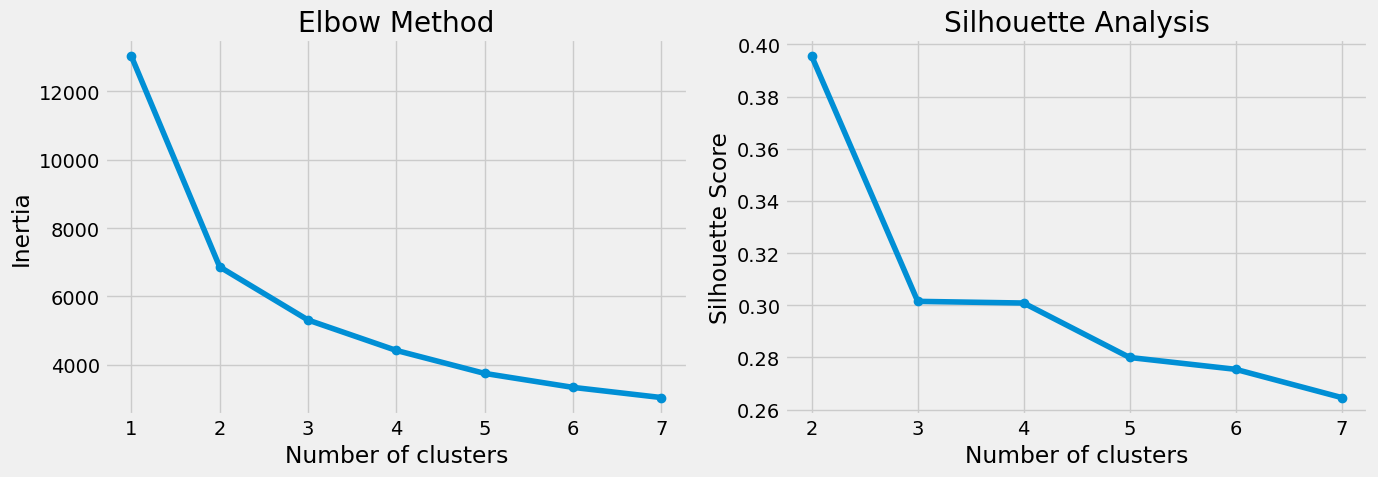

In [29]:
# Choosing no of Clusters
#First : Get the Best KMeans 
cluster_range = range(1,8)

# Plot clusters for different k  ++ Elbow method ++ silhouette_scores method
fig, axes = plt.subplots(1, len(cluster_range), figsize=(15, 5), sharey=True)
inertia = []
silhouette_scores = []

for i, k in enumerate(cluster_range):
    # Create a KMeans clusters
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(rfm_normalized)
    inertia.append(km.inertia_)
    if k>1:
        silhouette_scores.append(silhouette_score(rfm_normalized, km.labels_))
    else:
        silhouette_scores.append(None)
    y_kmeans = km.fit_predict(rfm_normalized)

    axes[i].scatter(rfm_normalized[:, 0], rfm_normalized[:, 1], c=y_kmeans, s=30, cmap='viridis')
    axes[i].scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='red', s=100, marker='x')
    axes[i].set_title(f'k={k}')
    axes[i].set_xlabel('Feature 1')
    if i == 0:
        axes[i].set_ylabel('Feature 2')

plt.suptitle('Cluster Visualizations for Different k')
plt.tight_layout()
plt.show()

    
# Plot Elbow Method
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
# Assuming 'cluster_range' and 'inertia' are defined
knee_locator = KneeLocator(cluster_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee
print(f"Optimal number of clusters (Knee locator): {optimal_k}")


# Calculate the first and second derivatives of inertia
first_derivative = np.diff(inertia)
second_derivative = np.diff(first_derivative)

# Find the index of the maximum change in the second derivative
optimal_k_index = np.argmin(second_derivative) + 1  # +1 because np.diff reduces dimensions by 1
optimal_k = cluster_range[optimal_k_index]

print(f"Optimal number of clusters (2nd derivative): {optimal_k}")

Optimal number of clusters (Knee locator): 2
Optimal number of clusters (2nd derivative): 6


Observations : 

- it's a close call, but available options for cluster sizes are (2,3,5,6)

## RFM - for -  Market Basket Analysis

we would like to segment into 3 categories Gold / Silver / bronze, later to apply Market Basket Analysis.

In [31]:
kc = KMeans(n_clusters= 3, n_init='auto', random_state=42)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm_select.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean', 'MonetaryValue': ['mean', 'count']}).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            70.0      63.0        1114.0  1869
1            15.0     258.0        6338.0   998
2           176.0      15.0         290.0  1471

#### Snake Plots to Understand and Compare Segments

Market research technique to compare different segments
Visual representation of each segment’s attributes
Need to first normalize data (center & scale)
Plot each cluster’s average normalized values of each attribute

In [32]:
rfm_normalized = pd.DataFrame(rfm_normalized,index=rfm_select.index,columns=rfm_select.columns)

rfm_normalized['K_Cluster'] = kc.labels_

rfm_normalized['General_Segment'] = rfm['General_Segment']

rfm_normalized.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each

rfm_melt = pd.melt(
    rfm_normalized, 
    id_vars=['CustomerID','General_Segment','K_Cluster'],
    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
    var_name='Metric',
    value_name='Value'
)
rfm_melt.head()

,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Silver,0,Recency,1.435150
1,12347.0,Gold,1,Recency,-1.953322
2,12348.0,Silver,0,Recency,0.382758
3,12349.0,Silver,0,Recency,-0.619761
4,12350.0,Bronze,2,Recency,1.401178


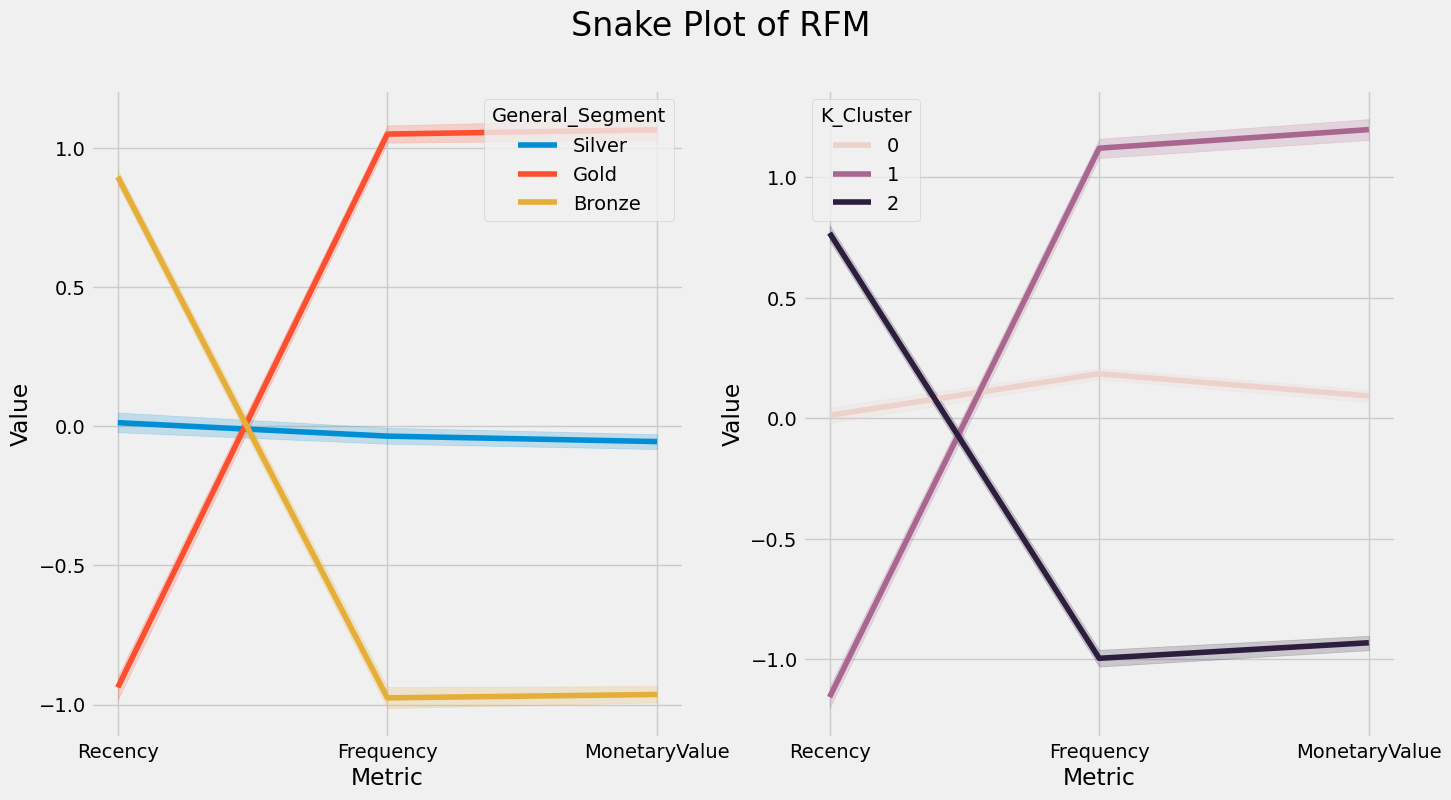

In [33]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))

sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

# a snake plot with K-Means

sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt,ax=ax2)

plt.suptitle("Snake Plot of RFM",fontsize=24) #make title fontsize subtitle 

plt.show()

# Apriori Algorithm
Apriori algorithm works on the principle of how two or more products/objects are associated with each other. 
In orther words, we can say that it is an algorithm that analyzes customers who bought product A also bought product B. 
Generally it works on datasets containing large number of transactions

In [34]:
basket_bronze = (Bronze_seg.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket_bronze.head() 

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,...,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536374.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536384.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536388.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536393.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536403.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Encode units : if units exists then 1, if no unit then 0
df_basket_bronze = basket_bronze.astype(int).applymap(lambda x : 0 if x<=0 else 1)
df_basket_bronze.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,...,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536374.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536384.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536388.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536393.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536403.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_basket_bronze.shape

(1712, 2819)

In [37]:
#Build frequent itemsets
frequent_itemsets_bronze = apriori(df_basket_bronze, min_support=0.0143, use_colnames=True)
frequent_itemsets_bronze['length'] = frequent_itemsets_bronze['itemsets'].apply(lambda x: len(x))
frequent_itemsets_bronze 

C:\Users\saila\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.015771,(4 TRADITIONAL SPINNING TOPS),1
1,0.022196,(6 RIBBONS RUSTIC CHARM),1
2,0.024533,(60 TEATIME FAIRY CAKE CASES),1
3,0.015187,(ALARM CLOCK BAKELIKE RED ),1
4,0.028621,(ANTIQUE SILVER T-LIGHT GLASS),1
...,...,...,...
126,0.015771,"(HEART OF WICKER LARGE, HEART OF WICKER SMALL)",2
127,0.016355,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",2
128,0.016355,"(WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI...",2
129,0.014603,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU...",2


In [38]:
rules_bronze = association_rules(frequent_itemsets_bronze, metric="lift", min_threshold=1, num_itemsets =2)
rules_bronze

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(PAINTED METAL PEARS ASSORTED),(ASSORTED COLOUR BIRD ORNAMENT),0.022196,0.049650,0.016939,0.763158,15.370898,1.0,0.015837,4.012591,0.956165,0.308511,0.750784,0.552167
1,(ASSORTED COLOUR BIRD ORNAMENT),(PAINTED METAL PEARS ASSORTED),0.049650,0.022196,0.016939,0.341176,15.370898,1.0,0.015837,1.484166,0.983787,0.308511,0.326221,0.552167
2,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT ),0.020444,0.043224,0.015771,0.771429,17.847104,1.0,0.014887,4.185894,0.963670,0.329268,0.761102,0.568147
3,(BAKING SET 9 PIECE RETROSPOT ),(BAKING SET SPACEBOY DESIGN),0.043224,0.020444,0.015771,0.364865,17.847104,1.0,0.014887,1.542280,0.986614,0.329268,0.351609,0.568147
4,(CANDLEHOLDER PINK HANGING HEART),(WHITE HANGING HEART T-LIGHT HOLDER),0.019860,0.085280,0.015771,0.794118,9.311845,1.0,0.014077,4.442924,0.910696,0.176471,0.774923,0.489525
5,(WHITE HANGING HEART T-LIGHT HOLDER),(CANDLEHOLDER PINK HANGING HEART),0.085280,0.019860,0.015771,0.184932,9.311845,1.0,0.014077,1.202525,0.975829,0.176471,0.168416,0.489525
6,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.023364,0.033879,0.019276,0.825000,24.351724,1.0,0.018484,5.520694,0.981876,0.507692,0.818863,0.696983
7,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.033879,0.023364,0.019276,0.568966,24.351724,1.0,0.018484,2.265794,0.992562,0.507692,0.558654,0.696983
8,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.033879,0.074182,0.017523,0.517241,6.972577,1.0,0.015010,1.917765,0.886618,0.193548,0.478560,0.376731
9,(REGENCY CAKESTAND 3 TIER),(GREEN REGENCY TEACUP AND SAUCER),0.074182,0.033879,0.017523,0.236220,6.972577,1.0,0.015010,1.264922,0.925216,0.193548,0.209437,0.376731


In [39]:
#Products having 70% confidence likely to be purchased together
rules_bronze[(rules_bronze['lift'] >= 6) & (rules_bronze['confidence'] >= 0.7)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(PAINTED METAL PEARS ASSORTED),(ASSORTED COLOUR BIRD ORNAMENT),0.022196,0.049650,0.016939,0.763158,15.370898,1.0,0.015837,4.012591,0.956165,0.308511,0.750784,0.552167
2,(BAKING SET SPACEBOY DESIGN),(BAKING SET 9 PIECE RETROSPOT ),0.020444,0.043224,0.015771,0.771429,17.847104,1.0,0.014887,4.185894,0.963670,0.329268,0.761102,0.568147
4,(CANDLEHOLDER PINK HANGING HEART),(WHITE HANGING HEART T-LIGHT HOLDER),0.019860,0.085280,0.015771,0.794118,9.311845,1.0,0.014077,4.442924,0.910696,0.176471,0.774923,0.489525
6,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.023364,0.033879,0.019276,0.825000,24.351724,1.0,0.018484,5.520694,0.981876,0.507692,0.818863,0.696983
11,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.031542,0.033879,0.022780,0.722222,21.318008,1.0,0.021712,3.478037,0.984133,0.534247,0.712482,0.697318
14,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.023364,0.031542,0.016355,0.700000,22.192593,1.0,0.015618,3.228193,0.977785,0.424242,0.690229,0.609259
17,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.022196,0.085280,0.016355,0.736842,8.640231,1.0,0.014462,3.475935,0.904335,0.179487,0.712308,0.464311
20,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.019276,0.031542,0.015187,0.787879,24.978676,1.0,0.014579,4.565587,0.978834,0.426230,0.780970,0.634680
21,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.016355,0.033879,0.015187,0.928571,27.408867,1.0,0.014633,13.525701,0.979536,0.433333,0.926067,0.688424


# Item Based Collaborative Filtering
It is an approach to predict the customers’ choice and find the products that customers might tend to buy on the basis of the data collected from a large number of different customers having similar choices or preferences. The basic consideration is that if person A and person B have some kind of reaction to some items, then they might have the same preferences or opinion towards other items too.


### Co-occurence Matrix

In [57]:
# Create a pivot table with StockCode as items and InvoiceNo as users
pivot_table = Bronze_seg.pivot_table(index='Description', columns='InvoiceNo', values='Quantity', fill_value=0)
pivot_table = pivot_table.astype(int).applymap(lambda x : 0 if x<=0 else 1)
pivot_table

InvoiceNo,536374.0,536384.0,536388.0,536393.0,536403.0,536409.0,536420.0,536464.0,536502.0,536508.0,...,577496.0,577537.0,577556.0,577604.0,577669.0,577716.0,577724.0,577738.0,577739.0,577755.0
Description,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50'S CHRISTMAS GIFT BAG LARGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I LOVE LONDON MINI BACKPACK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OVAL WALL MIRROR DIAMANTE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RED SPOT GIFT BAG LARGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZINC SWEETHEART WIRE LETTER RACK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZINC T-LIGHT HOLDER STAR LARGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZINC T-LIGHT HOLDER STARS SMALL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Compute cosine similarity between items
item_similarity = cosine_similarity(pivot_table)

# Create a DataFrame for similarity
item_similarity_df = pd.DataFrame(item_similarity, index=pivot_table.index, columns=pivot_table.index)
item_similarity_df

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,I LOVE LONDON MINI BACKPACK,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,...,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Description,,,,,,,,,,,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.267261,0.0,0.213201,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50'S CHRISTMAS GIFT BAG LARGE,0.0,1.00000,0.0,0.0,0.57735,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
I LOVE LONDON MINI BACKPACK,0.0,0.00000,1.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
OVAL WALL MIRROR DIAMANTE,0.0,0.00000,0.0,1.0,0.00000,0.086711,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.074125,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
RED SPOT GIFT BAG LARGE,0.0,0.57735,0.0,0.0,1.00000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZINC SWEETHEART WIRE LETTER RACK,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.158114
ZINC T-LIGHT HOLDER STAR LARGE,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.771517,0.0,0.000000
ZINC T-LIGHT HOLDER STARS SMALL,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.267261,0.000000,0.771517,1.000000,0.0,0.000000


In [63]:
item_similarity_df.index

Index([' 4 PURPLE FLOCK DINNER CANDLES', ' 50'S CHRISTMAS GIFT BAG LARGE',
       ' I LOVE LONDON MINI BACKPACK', ' OVAL WALL MIRROR DIAMANTE ',
       ' RED SPOT GIFT BAG LARGE', ' SET 2 TEA TOWELS I LOVE LONDON ',
       ' SPACEBOY BABY GIFT SET', '10 COLOUR SPACEBOY PEN',
       '12 COLOURED PARTY BALLOONS', '12 DAISY PEGS IN WOOD BOX',
       ...
       'ZINC HEART LATTICE T-LIGHT HOLDER', 'ZINC HEARTS PLANT POT HOLDER',
       'ZINC HERB GARDEN CONTAINER', 'ZINC METAL HEART DECORATION',
       'ZINC STAR T-LIGHT HOLDER ', 'ZINC SWEETHEART WIRE LETTER RACK',
       'ZINC T-LIGHT HOLDER STAR LARGE', 'ZINC T-LIGHT HOLDER STARS SMALL',
       'ZINC TOP  2 DOOR WOODEN SHELF ', 'ZINC WILLIE WINKIE  CANDLE STICK'],
      dtype='object', name='Description', length=2819)

In [66]:
# Function to recommend similar items
def recommend_similar_items(item_code, n=5):
    if item_code in item_similarity_df.index:
        similar_items = item_similarity_df[item_code].sort_values(ascending=False).head(n + 1)
        return similar_items[1:]  # Exclude the item itself
    else:
        return f"Item code {item_code} not found." 

# Example usage
item_code_to_check = item_similarity_df.index[0]  # Replace with an actual StockCode from your dataset
print(recommend_similar_items(item_code_to_check))

Description
STRAWBERRIES  DESIGN FLANNEL      0.707107
IVORY SCULPTED RND CANDLE         0.707107
FREESTYLE CANVAS ART PICTURE      0.707107
RED VINTAGE SPOT BEAKER           0.707107
LILAC DIAMANTE PEN IN GIFT BOX    0.500000
Name:  4 PURPLE FLOCK DINNER CANDLES, dtype: float64


## Comparison of Algorithms

- After running the algorithm for all the segments, this analysis shows that as the support values decreases 
  or move towards less than or equal to 0.01, 
  sometimes Apriori Algorithm fails to generate the frequent patterns as it gets involved in infinite loop. 
  Also, as minimum support increases the frequent item set generated decreases.

- To generate association rules for such heavy datasets, all the algorithms have different run-time due to their unique execution processes.